# Unsupervised pretraining

In [1]:
# Setup imports:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
# Using Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 1s 61ms/step - loss: 2.2651 - accuracy: 0.2093 - val_loss: 1.9777 - val_accuracy: 0.4184
Epoch 2/20
16/16 [==============================] - 1s 37ms/step - loss: 1.8718 - accuracy: 0.4904 - val_loss: 1.6259 - val_accuracy: 0.5408
Epoch 3/20
16/16 [==============================] - 1s 36ms/step - loss: 1.4719 - accuracy: 0.5774 - val_loss: 1.2590 - val_accuracy: 0.6036
Epoch 4/20
16/16 [==============================] - 1s 36ms/step - loss: 1.1272 - accuracy: 0.6754 - val_loss: 1.0043 - val_accuracy: 0.6886
Epoch 5/20
16/16 [==============================] - 1s 41ms/step - loss: 1.0450 - accuracy: 0.6360 - val_loss: 0.9249 - val_accuracy: 0.6932
Epoch 6/20
16/16 [==============================] - 1s 38ms/step - loss: 0.9584 - accuracy: 0.6508 - val_loss: 0.8596 - val_accuracy: 0.7004
Epoch 7/20
16/16 [==============================] - 1s 35ms/step - loss: 0.7987 - accuracy: 0.7431 - val_loss: 0.8069 - val_accuracy: 0.7024
Epoch 8/20
16

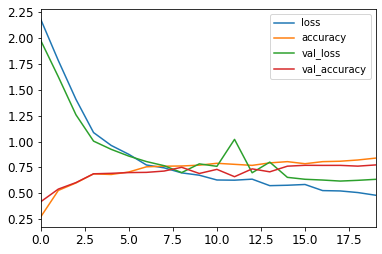

In [4]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [5]:
# utility metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [6]:
# code for convolutional auto-encoder:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3377 - rounded_accuracy: 0.8895 - val_loss: 0.2848 - val_rounded_accuracy: 0.9288
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2776 - rounded_accuracy: 0.9393 - val_loss: 0.2730 - val_rounded_accuracy: 0.9452
Epoch 3/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2717 - rounded_accuracy: 0.9452 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2690 - rounded_accuracy: 0.9484 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2668 - rounded_accuracy: 0.9506 - val_loss: 0.2674 - val_rounded_accuracy: 0.9504


In [7]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
# Having the trunk pre-trained provides higher accuracy
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 1s 40ms/step - loss: 2.3378 - accuracy: 0.1521 - val_loss: 2.2306 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 0s 33ms/step - loss: 2.2126 - accuracy: 0.2548 - val_loss: 2.1302 - val_accuracy: 0.3560
Epoch 3/30
16/16 [==============================] - 0s 33ms/step - loss: 2.1059 - accuracy: 0.3816 - val_loss: 2.0362 - val_accuracy: 0.4132
Epoch 4/30
16/16 [==============================] - 1s 33ms/step - loss: 2.0001 - accuracy: 0.4831 - val_loss: 1.9561 - val_accuracy: 0.5152
Epoch 5/30
16/16 [==============================] - 1s 33ms/step - loss: 1.9365 - accuracy: 0.5318 - val_loss: 1.8746 - val_accuracy: 0.5920
Epoch 6/30
16/16 [==============================] - 0s 33ms/step - loss: 1.8599 - accuracy: 0.5879 - val_loss: 1.7987 - val_accuracy: 0.6340
Epoch 7/30
16/16 [==============================] - 1s 34ms/step - loss: 1.7754 - accuracy: 0.6632 - val_loss: 1.7221 - val_accuracy: 0.6414
Epoch 8/30
16

In [10]:
# If the trunk is open for training accuracy is even better
# Note how small dataset we are using for training
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 1s 43ms/step - loss: 0.3851 - accuracy: 0.8556 - val_loss: 0.5952 - val_accuracy: 0.7686
Epoch 2/20
16/16 [==============================] - 1s 36ms/step - loss: 0.3774 - accuracy: 0.8820 - val_loss: 0.5757 - val_accuracy: 0.7898
Epoch 3/20
16/16 [==============================] - 1s 35ms/step - loss: 0.3381 - accuracy: 0.8902 - val_loss: 0.6026 - val_accuracy: 0.7788
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 0.3771 - accuracy: 0.8641 - val_loss: 0.5949 - val_accuracy: 0.7860
Epoch 5/20
16/16 [==============================] - 1s 43ms/step - loss: 0.3924 - accuracy: 0.8630 - val_loss: 0.5610 - val_accuracy: 0.7866
Epoch 6/20
16/16 [==============================] - 1s 37ms/step - loss: 0.3641 - accuracy: 0.8711 - val_loss: 0.5968 - val_accuracy: 0.7776
Epoch 7/20
16/16 [==============================] - 1s 76ms/step - loss: 0.3426 - accuracy: 0.8791 - val_loss: 0.5724 - val_accuracy: 0.7950
Epoch 8/20
16